In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.linalg import cholesky, lstsq


In [2]:
from experiments import EffectCorrelation
from experiments import utilities as utils
from bayesinverse import Regression


In [3]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/effect_correlation/config.yaml"
)

exp = EffectCorrelation(config_path)


sensors 0.009111359715461731
emissions 9.34604400396347
transport 50.81644280254841


In [4]:
meteo_seed = 2
n_processes = 32
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes=n_processes, seed=meteo_seed
)


loop start 40.875974372029305
loop end 40.91163319349289


In [5]:
u, s, vh = np.linalg.svd(
        exp.emissions.prior_covariance.stack(
            test=("source_group", "time_state"),
            test2=("source_group_2", "time_state_2"),
    )
)


In [6]:
cov_sqrt_inv = u @ np.diag(np.sqrt(1/s)) @ vh

In [7]:
cov_sqrt_inv @ cov_sqrt_inv @ exp.emissions.prior_covariance.stack(
    test=("source_group", "time_state"),
    test2=("source_group_2", "time_state_2"),
).values


array([[ 1.00000000e+00, -5.49749562e-16, -1.04756978e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.76378706e-16,  1.00000000e+00, -2.67023217e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.03734969e-15,  8.71718277e-16,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  5.86292348e-16, -1.45899419e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.54822363e-17,  1.00000000e+00,  6.66133815e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.24966930e-16, -2.30172146e-16,  1.00000000e+00]])

In [8]:
utils.stack_xr(exp.emissions.prior_covariance)

<xarray.DataArray (state: 2016, state_2: 2016)>
array([[1.        , 0.36787944, 0.13533528, ..., 0.        , 0.        ,
        0.        ],
       [0.36787944, 1.        , 0.36787944, ..., 0.        , 0.        ,
        0.        ],
       [0.13533528, 0.36787944, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.36787944,
        0.13533528],
       [0.        , 0.        , 0.        , ..., 0.36787944, 1.        ,
        0.36787944],
       [0.        , 0.        , 0.        , ..., 0.13533528, 0.36787944,
        1.        ]])
Coordinates:
  * state           (state) MultiIndex
  - source_group    (state) int64 1 1 1 1 1 1 1 1 1 ... 39 39 39 39 39 39 39 39
  - time_state      (state) int64 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
  * state_2         (state_2) MultiIndex
  - source_group_2  (state_2) int64 1 1 1 1 1 1 1 1 ... 39 39 39 39 39 39 39 39
  - time_state_2    (state_2) int64 0 1 2 3 4 5 6 7 ... 88 89 90 91 92 93 94 95

In [9]:
reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)


In [10]:
np.linalg.det(utils.stack_xr(exp.emissions.prior_covariance))

1.0237950982294561e-126

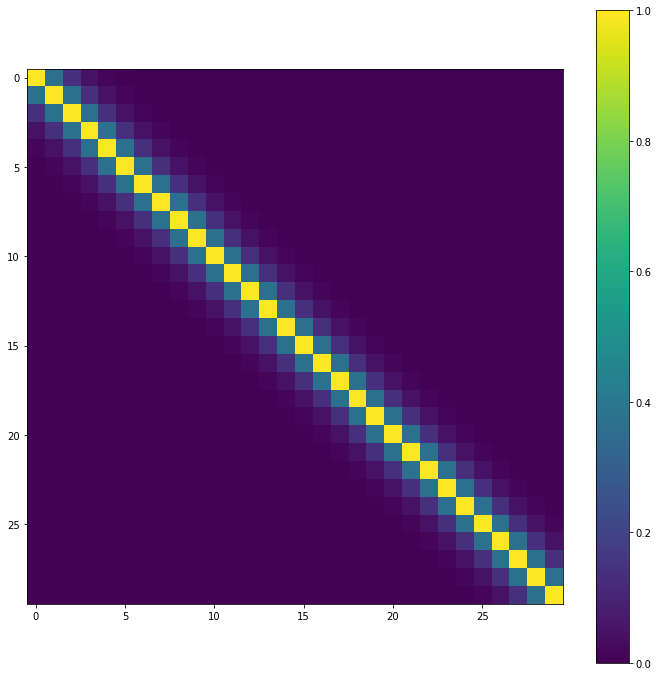

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:30, :30])
plt.colorbar()


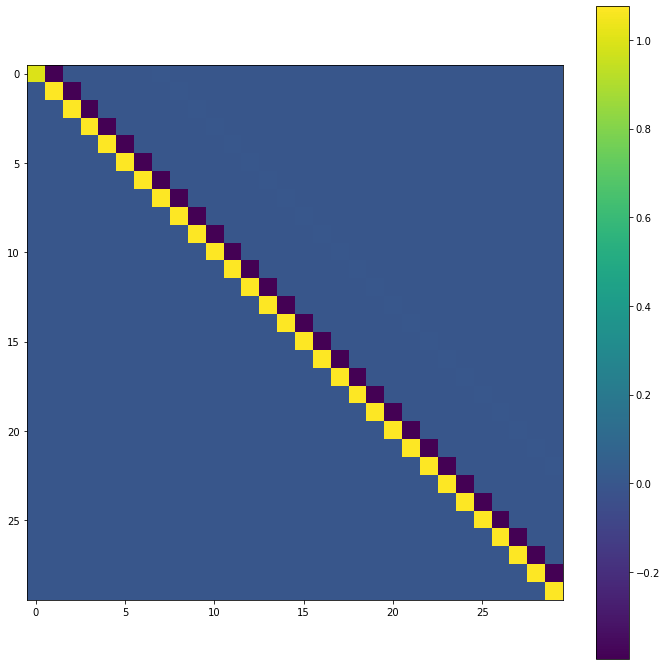

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(reg.model.x_covariance_inv_sqrt[:30, :30])
plt.colorbar()


In [13]:
reg.get_averaging_kernel().min()

-0.1696065436836896

In [14]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]


In [15]:
corr_strength_list = [1e-8 + 0.5 * i for i in range(10)]
tau_h = 1.
tau_d = .00001

reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)

rmse_list = []
posterior_list = []
for corr_strength in corr_strength_list:
    print(corr_strength)
    prior_covariance = utils.compute_prior_covariance(
        xr_prior_var=exp.emissions.prior_variance,
        tau_h=corr_strength * tau_h,
        tau_d=corr_strength * tau_d,
    )
    reg.set_x_covariance(utils.stack_xr(prior_covariance))
    x_est, _, _, _ = reg.fit()
    x_posterior = exp.emissions.to_xr(x_est)
    x_posterior = utils.unstack_xr(x_posterior) * true_emissions

    error = x_posterior - exp.emissions.truth_absolute
    rmse = np.sqrt(np.mean(error.sum("source_group")**2))
    # rmse = np.mean(
    #     np.abs(
    #         (
    #             exp.emissions.truth_absolute.sum("source_group")
    #             - (utils.unstack_xr(x_posterior) * exp.emissions.truth_absolute).sum(
    #                 "source_group"
    #             )
    #         )
    #     )
    # )
    rmse_list.append(rmse)
    posterior_list.append(x_posterior)


1e-08
0.50000001
1.00000001
1.50000001
2.00000001
2.50000001
3.00000001
3.50000001
4.00000001
4.50000001


In [16]:
a = utils.stack_xr(exp.emissions.truth - exp.emissions.truth.mean())[0:-1]
b = utils.stack_xr(exp.emissions.truth - exp.emissions.truth.mean())[1:]
    

In [17]:
np.mean((a - a.mean())*(b - b.mean()))/a.std()/b.std()

<xarray.DataArray ()>
array(1.00021459)

In [40]:
rmse_area_list = []
for x_posterior in posterior_list:
    error = x_posterior - exp.emissions.truth_absolute
    rmse = np.sqrt(
        np.mean(error.isel(source_group=slice(1, None)).sum("source_group") ** 2)
    )
    rmse_area_list.append(rmse)


In [42]:
rel_rmse_area_list = []
for x_posterior in posterior_list:
    error = x_posterior - exp.emissions.truth_absolute
    rmse = (
        np.sqrt(
            np.mean(error.isel(source_group=slice(1, None)).sum("source_group") ** 2)
        )
        / exp.emissions.truth_absolute.isel(source_group=slice(1, None))
        .sum("source_group")
        .mean()
        * 100
    )
    rel_rmse_area_list.append(rmse)


In [44]:
# Save data
exp.data["rmse_list"] = rmse_list
exp.data["rmse_area_list"] = rmse_area_list
exp.data["rel_rmse_area_list"] = rel_rmse_area_list

exp.pickle_data()

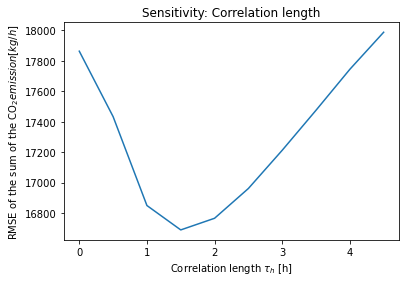

In [49]:
plt.plot(corr_strength_list, rmse_list)
plt.title("Sensitivity: Correlation length")
plt.xlabel(r"Correlation length $\tau_h$ [h]")
plt.ylabel(r"RMSE of the sum of the CO$_2 emission [kg/h]$")
plt.savefig("/home/rmaiwald/results/preliminary/effect_correlation")

Text(0, 0.5, 'RMSE of the sum of the CO$_2 emission [kg/h]$')

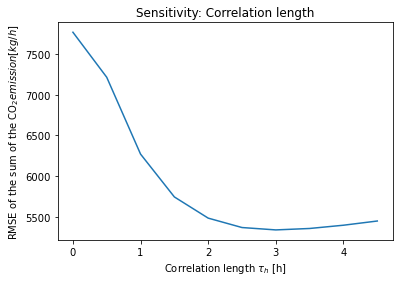

In [48]:
plt.plot(corr_strength_list, rmse_area_list)
plt.title("Sensitivity: Correlation length")
plt.xlabel(r"Correlation length $\tau_h$ [h]")
plt.ylabel(r"RMSE of the sum of the CO$_2 emission [kg/h]$")

'relative error'

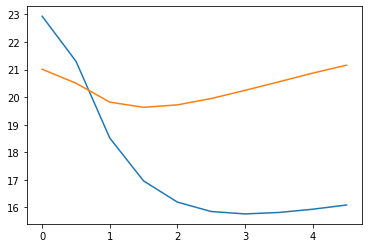

In [29]:
plt.plot(corr_strength_list, rmse_area_list)
plt.plot(
    corr_strength_list,
    (
        np.array(rmse_list)
        / exp.emissions.truth_absolute
        .sum("source_group")
        .values.mean()
        * 100
    ),
)
plt.title("Sensitivity: Correlation length")
plt.xlabel(r"Correlation length $\tau_h$ [h]")
plt.ylabel(r"RMSE of the sum of the CO$_2 emission [kg/h]$")

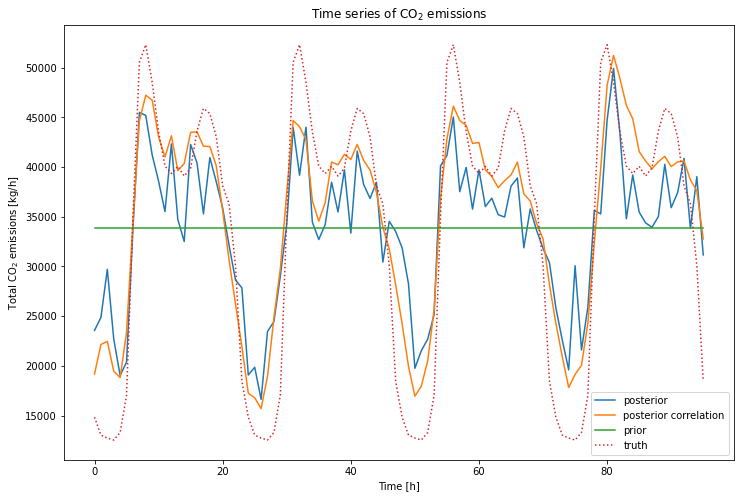

In [50]:
plt.figure(figsize=(12, 8))
mean = posterior_list[0].isel(source_group=slice(1, None)).sum("source_group")
line = plt.plot(mean, "-", label="posterior")[0]
mean = posterior_list[-1].isel(source_group=slice(1, None)).sum("source_group")
line = plt.plot(mean, "-", label="posterior correlation")[0]

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
line = plt.plot(mean_prior, label="prior")[0]


plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/effect_correlation_timeseries")

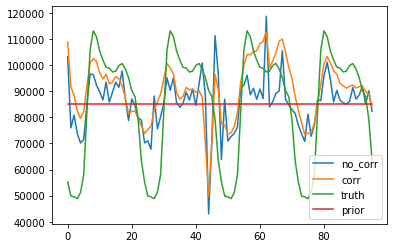

In [22]:
plt.plot(
    (utils.unstack_xr(posterior_list[0])).sum("source_group"),
    "-",
    label="no_corr",
)
plt.plot(
    (utils.unstack_xr(posterior_list[-1])).sum("source_group"),
    "-",
    label="corr"
)
plt.plot(exp.emissions.truth_absolute.sum("source_group"), label="truth")
plt.plot(exp.emissions.prior_absolute.sum("source_group"), label="prior")
plt.legend()

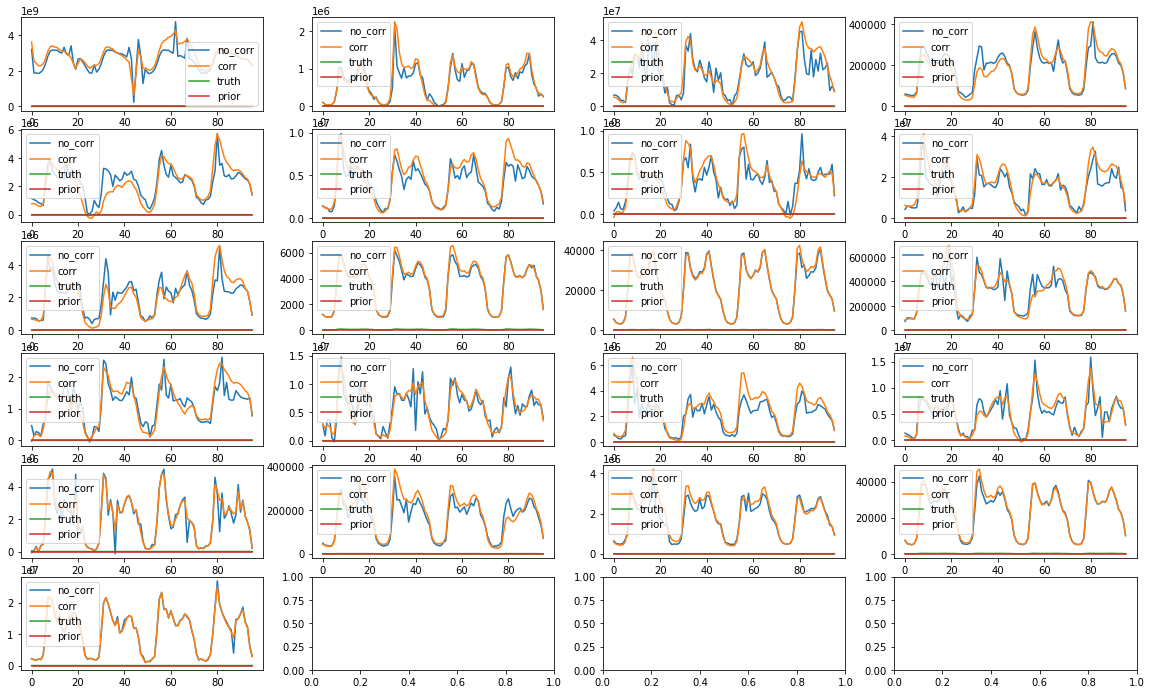

In [23]:
fig, axs = plt.subplots(figsize=(20, 12), nrows=6, ncols=4)

axs = axs.flatten()

for i in range(len(exp.emissions.prior["source_group"])):
    ax = axs[i]
    ax.plot(
        (utils.unstack_xr(posterior_list[0]) * exp.emissions.truth_absolute).isel(
            source_group=i
        ),
        "-",
        label="no_corr",
    )
    ax.plot(
        (utils.unstack_xr(posterior_list[-1]) * exp.emissions.truth_absolute).isel(
            source_group=i
        ),
        "-",
        label="corr",
    )
    ax.plot(exp.emissions.truth_absolute.isel(source_group=i), label="truth")
    ax.plot(exp.emissions.prior_absolute.isel(source_group=i), label="prior")
    ax.legend()


In [24]:
t = np.arange(100)
y = (
    0.6
    + 0.1 * np.cos(2 * np.pi / 24 * (t + 12))
    + 0.3 * np.abs(np.cos(2 * np.pi / 24 * (t + 3)))
)


In [25]:
y.sum()

78.31568181730107

In [26]:
a = np.random.random(100)
b = 0.5 * np.random.random(100) + a

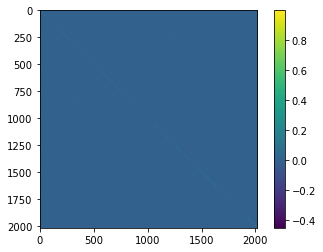

In [27]:
im = plt.imshow(reg.get_averaging_kernel())
plt.colorbar(im)

In [28]:
reg.get_averaging_kernel().max()

0.9982145037947503